In [70]:
import pandas as pd
import re
import contractions
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/knysh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/knysh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/knysh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/knysh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/knysh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Data cleaning

In [71]:
# Load data
df = pd.read_csv('books_200mb.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  199999 non-null  object 
 1   Title               199998 non-null  object 
 2   Price               32947 non-null   float64
 3   User_id             160870 non-null  object 
 4   profileName         160862 non-null  object 
 5   review/helpfulness  199999 non-null  object 
 6   review/score        199999 non-null  float64
 7   review/time         199999 non-null  int64  
 8   review/summary      199997 non-null  object 
 9   review/text         199999 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB
None


In [72]:
# Remove redundant columns and rename the rest
df = df.loc[:, ['Title', 'review/text', 'review/score', 'review/helpfulness']]
df.rename(columns={
    'Title': 'title',
    'review/text': 'text',
    'review/score': 'score',
    'review/helpfulness': 'helpfulness'
}, inplace=True)

# Score value: integer from 0 (worse score) to 5 (best score)
df.score = df.score.astype(int)

df.head(5)

,title,text,score,helpfulness
0,Its Only Art If Its Well Hung!,This is only for Julie Strain fans. It's a col...,4,7/7
1,Dr. Seuss: American Icon,I don't care much for Dr. Seuss but after read...,5,10/10
2,Dr. Seuss: American Icon,"If people become the books they read and if ""t...",5,10/11
3,Dr. Seuss: American Icon,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",4,7/7
4,Dr. Seuss: American Icon,Philip Nel - Dr. Seuss: American IconThis is b...,4,3/3


In [73]:
# Check for missing values
df.isna().any()

title           True
text           False
score          False
helpfulness    False
dtype: bool

In [74]:
# Remove null values
df.dropna(how='any', inplace=True)
df.isna().any()

title          False
text           False
score          False
helpfulness    False
dtype: bool

In [75]:
# Maps helpfulness score to 0 or 1 depending on n/m rating.
def map_helpfulness(x: str):
    x1, x2 = list(map(int, x.split('/')))
    return 1 if x1 / (x2 or 1) >= 0.5 else 0

df.helpfulness = df.helpfulness.apply(map_helpfulness)
df.head(10)

,title,text,score,helpfulness
0,Its Only Art If Its Well Hung!,This is only for Julie Strain fans. It's a col...,4,1
1,Dr. Seuss: American Icon,I don't care much for Dr. Seuss but after read...,5,1
2,Dr. Seuss: American Icon,"If people become the books they read and if ""t...",5,1
3,Dr. Seuss: American Icon,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",4,1
4,Dr. Seuss: American Icon,Philip Nel - Dr. Seuss: American IconThis is b...,4,1
5,Dr. Seuss: American Icon,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",4,1
6,Dr. Seuss: American Icon,Theodor Seuss Giesel was best known as 'Dr. Se...,5,1
7,Dr. Seuss: American Icon,When I recieved this book as a gift for Christ...,5,0
8,Dr. Seuss: American Icon,Trams (or any public transport) are not usuall...,5,0
9,Dr. Seuss: American Icon,"As far as I am aware, this is the first book-l...",4,1


#### Texts cleaning:
Remove HTML, URLs, punctuation

In [76]:
# Step 1-2: text clean-up
def clean_text(text):
    # convert to lowercase
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    # remove URLs
    text = re.sub(r'https?:\/\/\S+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

df['text'] = df['text'].apply(clean_text)
df['text']

0         this is only for julie strain fans it is a col...
1         i do not care much for dr seuss but after read...
2         if people become the books they read and if th...
3         theodore seuss geisel 19041991 aka quotdr seus...
4         philip nel  dr seuss american iconthis is basi...
                                ...                        
199994    this is a book that should change the way the ...
199995    the dialectic of enlightenment is a history of...
199996    review by aprabaharan centre for the study of ...
199997    perhaps the single most important book that i ...
199998    the classic text of the frankfurt school remai...
Name: text, Length: 199998, dtype: object

#### Tokenization:
Split the texts into a seperate words (tokens)

In [77]:
# Step 3: tokenize the text
def tokenize_text(text):
    # use the word_tokenize method from the NLTK library to tokenize the text
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['text'].apply(tokenize_text)
df['tokens']

0         [this, is, only, for, julie, strain, fans, it,...
1         [i, do, not, care, much, for, dr, seuss, but, ...
2         [if, people, become, the, books, they, read, a...
3         [theodore, seuss, geisel, 19041991, aka, quotd...
4         [philip, nel, dr, seuss, american, iconthis, i...
                                ...                        
199994    [this, is, a, book, that, should, change, the,...
199995    [the, dialectic, of, enlightenment, is, a, his...
199996    [review, by, aprabaharan, centre, for, the, st...
199997    [perhaps, the, single, most, important, book, ...
199998    [the, classic, text, of, the, frankfurt, schoo...
Name: tokens, Length: 199998, dtype: object

#### Remove stop-words

In [78]:
# Step 4: stopwords removal
def remove_stopwords(tokens):
    # load the list of English stopwords from the NLTK library
    stop_words = set(stopwords.words('english'))
    # remove stopwords from the list of words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)
df['tokens']

0         [julie, strain, fans, collection, photos, 80, ...
1         [care, much, dr, seuss, reading, philip, nels,...
2         [people, become, books, read, child, father, m...
3         [theodore, seuss, geisel, 19041991, aka, quotd...
4         [philip, nel, dr, seuss, american, iconthis, b...
                                ...                        
199994    [book, change, way, average, american, thinks,...
199995    [dialectic, enlightenment, history, false, app...
199996    [review, aprabaharan, centre, study, ssocial, ...
199997    [perhaps, single, important, book, ever, read,...
199998    [classic, text, frankfurt, school, remains, am...
Name: tokens, Length: 199998, dtype: object

In [79]:
df['num_tokens'] = df['tokens'].apply(len)

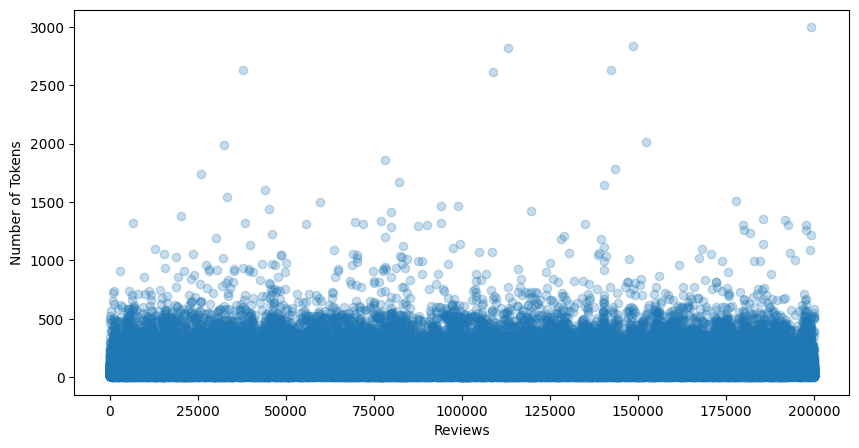

In [80]:
# create a scatter plot of `num_tokens`
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(df.index, df['num_tokens'], alpha=0.25)
plt.xlabel('Reviews')
plt.ylabel('Number of Tokens')
plt.show()

#### Lemmatization
Reduce words to their root form, taking into consideration the context and part of speech

In [81]:
# Map WordNet tags to NLTK tags
tag_dict = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV,
    "J": wordnet.ADJ
}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    # list to store the lemmatized tokens
    lemmatized_tokens = []
    for token in tokens:
        pos_tag = get_wordnet_pos(token)
        # get the corresponding NLTK tag for the WordNet tag
        nltk_pos_tag = tag_dict.get(pos_tag[0].upper(), wordnet.NOUN)
        # lemmatize the token with the appropriate tag
        lemmatized_token = lemmatizer.lemmatize(token, nltk_pos_tag)
        lemmatized_tokens.append(lemmatized_token)

    return lemmatized_tokens

df['lemmas'] = df['tokens'].apply(lemmatize_tokens)
df[['tokens', 'lemmas']]

,tokens,lemmas
0,"[julie, strain, fans, collection, photos, 80, ...","[julie, strain, fan, collection, photo, 80, pa..."
1,"[care, much, dr, seuss, reading, philip, nels,...","[care, much, dr, seuss, reading, philip, nels,..."
2,"[people, become, books, read, child, father, m...","[people, become, book, read, child, father, ma..."
3,"[theodore, seuss, geisel, 19041991, aka, quotd...","[theodore, seuss, geisel, 19041991, aka, quotd..."
4,"[philip, nel, dr, seuss, american, iconthis, b...","[philip, nel, dr, seuss, american, iconthis, b..."
...,...,...
199994,"[book, change, way, average, american, thinks,...","[book, change, way, average, american, think, ..."
199995,"[dialectic, enlightenment, history, false, app...","[dialectic, enlightenment, history, false, app..."
199996,"[review, aprabaharan, centre, study, ssocial, ...","[review, aprabaharan, centre, study, ssocial, ..."
199997,"[perhaps, single, important, book, ever, read,...","[perhaps, single, important, book, ever, read,..."


In [82]:
df['lemmas_str'] = df['lemmas'].apply(lambda l: ' '.join(l))

#### Sentiment Analysis

In [83]:
# sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# apply the analyzer to each review and store the results in a new column 'sentiment'
df['compound_score'] = df['lemmas_str'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df

,title,text,score,helpfulness,tokens,num_tokens,lemmas,lemmas_str,compound_score
0,Its Only Art If Its Well Hung!,this is only for julie strain fans it is a col...,4,1,"[julie, strain, fans, collection, photos, 80, ...",44,"[julie, strain, fan, collection, photo, 80, pa...",julie strain fan collection photo 80 page wort...,0.8910
1,Dr. Seuss: American Icon,i do not care much for dr seuss but after read...,5,1,"[care, much, dr, seuss, reading, philip, nels,...",133,"[care, much, dr, seuss, reading, philip, nels,...",care much dr seuss reading philip nels book ch...,0.9834
2,Dr. Seuss: American Icon,if people become the books they read and if th...,5,1,"[people, become, books, read, child, father, m...",162,"[people, become, book, read, child, father, ma...",people become book read child father man dr se...,0.9922
3,Dr. Seuss: American Icon,theodore seuss geisel 19041991 aka quotdr seus...,4,1,"[theodore, seuss, geisel, 19041991, aka, quotd...",343,"[theodore, seuss, geisel, 19041991, aka, quotd...",theodore seuss geisel 19041991 aka quotdr seus...,0.9776
4,Dr. Seuss: American Icon,philip nel dr seuss american iconthis is basi...,4,1,"[philip, nel, dr, seuss, american, iconthis, b...",140,"[philip, nel, dr, seuss, american, iconthis, b...",philip nel dr seuss american iconthis basicall...,0.9610
...,...,...,...,...,...,...,...,...,...
199994,Dialectic of Enlightenment (Cultural Memory in...,this is a book that should change the way the ...,5,1,"[book, change, way, average, american, thinks,...",582,"[book, change, way, average, american, think, ...",book change way average american think yes eas...,0.9758
199995,Dialectic of Enlightenment (Cultural Memory in...,the dialectic of enlightenment is a history of...,5,1,"[dialectic, enlightenment, history, false, app...",95,"[dialectic, enlightenment, history, false, app...",dialectic enlightenment history false appearan...,-0.6597
199996,Dialectic of Enlightenment (Cultural Memory in...,review by aprabaharan centre for the study of ...,5,1,"[review, aprabaharan, centre, study, ssocial, ...",242,"[review, aprabaharan, centre, study, ssocial, ...",review aprabaharan centre study ssocial system...,-0.6378
199997,Dialectic of Enlightenment (Cultural Memory in...,perhaps the single most important book that i ...,5,1,"[perhaps, single, important, book, ever, read,...",32,"[perhaps, single, important, book, ever, read,...",perhaps single important book ever read adorno...,0.9735


In [84]:
# score and helpfulness weights
score_weight = 0.3
helpfulness_weight = 0.1

# sentiment polarity weight
sentiment_weight = 1 - score_weight - helpfulness_weight

# compute the compound score based on the sentiment polarity, the score, and the helpfulness score
def compute_compound_score(row):
    sentiment = analyzer.polarity_scores(row['text'])['compound']

    # check if the polarity is consistent with the user score and adjust
    if (sentiment > 0 and row['score'] < 3) or (sentiment < 0 and row['score'] > 3):
        sentiment = -sentiment

    _score = score_weight * row['score'] / 5
    _helpfulness = helpfulness_weight * row['helpfulness']
    _sentiment = sentiment_weight * sentiment

    # compute the compound score
    compound_score = _score + _helpfulness + _sentiment

    return compound_score

df['compound_score'] = df.apply(compute_compound_score, axis=1)
df

,title,text,score,helpfulness,tokens,num_tokens,lemmas,lemmas_str,compound_score
0,Its Only Art If Its Well Hung!,this is only for julie strain fans it is a col...,4,1,"[julie, strain, fans, collection, photos, 80, ...",44,"[julie, strain, fan, collection, photo, 80, pa...",julie strain fan collection photo 80 page wort...,0.90448
1,Dr. Seuss: American Icon,i do not care much for dr seuss but after read...,5,1,"[care, much, dr, seuss, reading, philip, nels,...",133,"[care, much, dr, seuss, reading, philip, nels,...",care much dr seuss reading philip nels book ch...,0.99238
2,Dr. Seuss: American Icon,if people become the books they read and if th...,5,1,"[people, become, books, read, child, father, m...",162,"[people, become, book, read, child, father, ma...",people become book read child father man dr se...,0.99592
3,Dr. Seuss: American Icon,theodore seuss geisel 19041991 aka quotdr seus...,4,1,"[theodore, seuss, geisel, 19041991, aka, quotd...",343,"[theodore, seuss, geisel, 19041991, aka, quotd...",theodore seuss geisel 19041991 aka quotdr seus...,0.92734
4,Dr. Seuss: American Icon,philip nel dr seuss american iconthis is basi...,4,1,"[philip, nel, dr, seuss, american, iconthis, b...",140,"[philip, nel, dr, seuss, american, iconthis, b...",philip nel dr seuss american iconthis basicall...,0.92704
...,...,...,...,...,...,...,...,...,...
199994,Dialectic of Enlightenment (Cultural Memory in...,this is a book that should change the way the ...,5,1,"[book, change, way, average, american, thinks,...",582,"[book, change, way, average, american, think, ...",book change way average american think yes eas...,0.97396
199995,Dialectic of Enlightenment (Cultural Memory in...,the dialectic of enlightenment is a history of...,5,1,"[dialectic, enlightenment, history, false, app...",95,"[dialectic, enlightenment, history, false, app...",dialectic enlightenment history false appearan...,0.50302
199996,Dialectic of Enlightenment (Cultural Memory in...,review by aprabaharan centre for the study of ...,5,1,"[review, aprabaharan, centre, study, ssocial, ...",242,"[review, aprabaharan, centre, study, ssocial, ...",review aprabaharan centre study ssocial system...,0.78640
199997,Dialectic of Enlightenment (Cultural Memory in...,perhaps the single most important book that i ...,5,1,"[perhaps, single, important, book, ever, read,...",32,"[perhaps, single, important, book, ever, read,...",perhaps single important book ever read adorno...,0.98464


In [85]:
def map_sentiment(row):
    if row['compound_score'] >= 0.3:
        return 'positive'
    elif row['compound_score'] <= -0.3:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df.apply(map_sentiment, axis=1)
df

,title,text,score,helpfulness,tokens,num_tokens,lemmas,lemmas_str,compound_score,sentiment
0,Its Only Art If Its Well Hung!,this is only for julie strain fans it is a col...,4,1,"[julie, strain, fans, collection, photos, 80, ...",44,"[julie, strain, fan, collection, photo, 80, pa...",julie strain fan collection photo 80 page wort...,0.90448,positive
1,Dr. Seuss: American Icon,i do not care much for dr seuss but after read...,5,1,"[care, much, dr, seuss, reading, philip, nels,...",133,"[care, much, dr, seuss, reading, philip, nels,...",care much dr seuss reading philip nels book ch...,0.99238,positive
2,Dr. Seuss: American Icon,if people become the books they read and if th...,5,1,"[people, become, books, read, child, father, m...",162,"[people, become, book, read, child, father, ma...",people become book read child father man dr se...,0.99592,positive
3,Dr. Seuss: American Icon,theodore seuss geisel 19041991 aka quotdr seus...,4,1,"[theodore, seuss, geisel, 19041991, aka, quotd...",343,"[theodore, seuss, geisel, 19041991, aka, quotd...",theodore seuss geisel 19041991 aka quotdr seus...,0.92734,positive
4,Dr. Seuss: American Icon,philip nel dr seuss american iconthis is basi...,4,1,"[philip, nel, dr, seuss, american, iconthis, b...",140,"[philip, nel, dr, seuss, american, iconthis, b...",philip nel dr seuss american iconthis basicall...,0.92704,positive
...,...,...,...,...,...,...,...,...,...,...
199994,Dialectic of Enlightenment (Cultural Memory in...,this is a book that should change the way the ...,5,1,"[book, change, way, average, american, thinks,...",582,"[book, change, way, average, american, think, ...",book change way average american think yes eas...,0.97396,positive
199995,Dialectic of Enlightenment (Cultural Memory in...,the dialectic of enlightenment is a history of...,5,1,"[dialectic, enlightenment, history, false, app...",95,"[dialectic, enlightenment, history, false, app...",dialectic enlightenment history false appearan...,0.50302,positive
199996,Dialectic of Enlightenment (Cultural Memory in...,review by aprabaharan centre for the study of ...,5,1,"[review, aprabaharan, centre, study, ssocial, ...",242,"[review, aprabaharan, centre, study, ssocial, ...",review aprabaharan centre study ssocial system...,0.78640,positive
199997,Dialectic of Enlightenment (Cultural Memory in...,perhaps the single most important book that i ...,5,1,"[perhaps, single, important, book, ever, read,...",32,"[perhaps, single, important, book, ever, read,...",perhaps single important book ever read adorno...,0.98464,positive


#### Visual Analysis

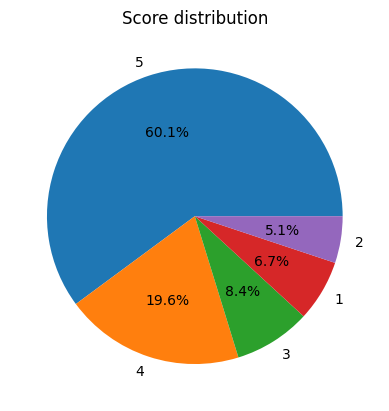

In [86]:
score_counts = df['score'].value_counts()
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%')
plt.title('Score distribution')
plt.show()

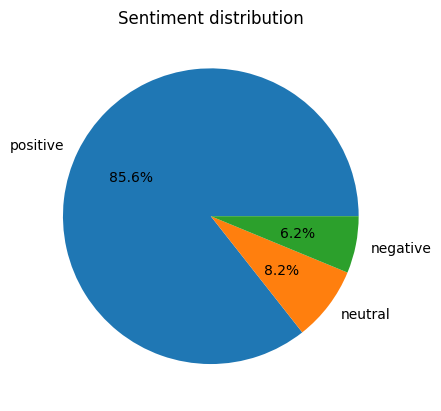

In [87]:
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%');
plt.title('Sentiment distribution')
plt.show()

[Text(0.5, 0, 'Number of words'), Text(0, 0.5, 'Sentiment')]

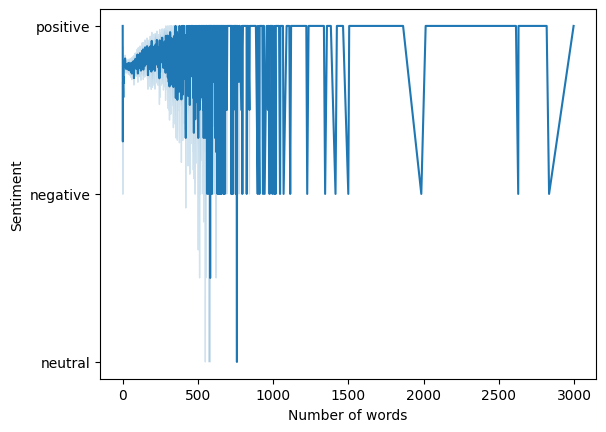

In [88]:
ax = sns.lineplot(data=df, x='num_tokens', y='sentiment')
ax.set(xlabel='Number of words', ylabel='Sentiment')

[Text(0.5, 0, 'Number of words'), Text(0, 0.5, 'Sentiment')]

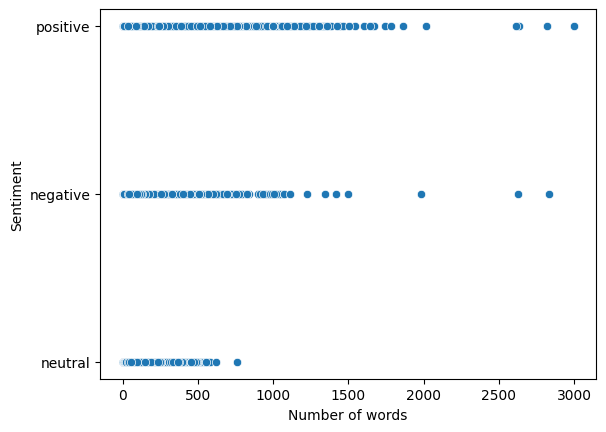

In [89]:
ax = sns.scatterplot(data=df, x='num_tokens', y='sentiment')
ax.set(xlabel='Number of words', ylabel='Sentiment')

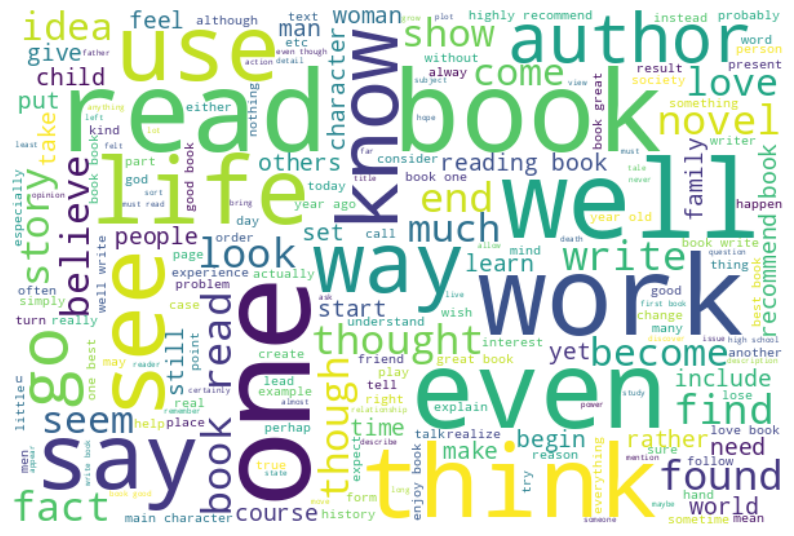

In [95]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=600,
                      height=400,
                      random_state=2,
                      background_color='white',
                      max_font_size=100).generate(' '.join(df['lemmas'].explode().astype(str).tolist()))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

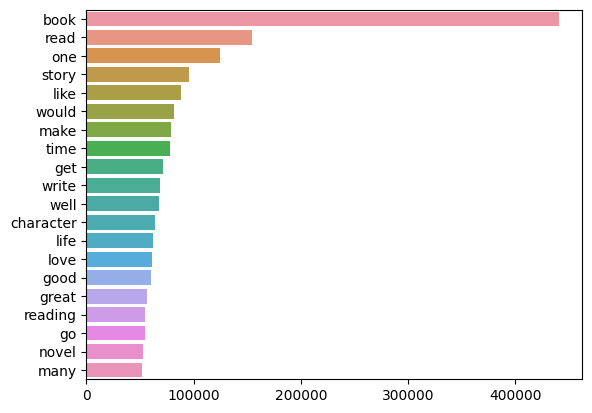

In [96]:
from nltk import FreqDist

fdist = FreqDist(df['lemmas'].explode().tolist())
fdist_top20 = fdist.most_common(20)

fdist_sr = pd.Series(dict(fdist_top20))
sns.barplot(y=fdist_sr.index, x=fdist_sr.values);

In [97]:
fd_adj = FreqDist()
fd_vrb = FreqDist()

for w in fdist.most_common(1000):
    pos = nltk.pos_tag(nltk.word_tokenize(w[0]))
    tag = pos[0][1]
    if tag == 'JJ':
        fd_adj[w[0]] = w[1]
    if tag == 'VB':
        fd_vrb[w[0]] = w[1]

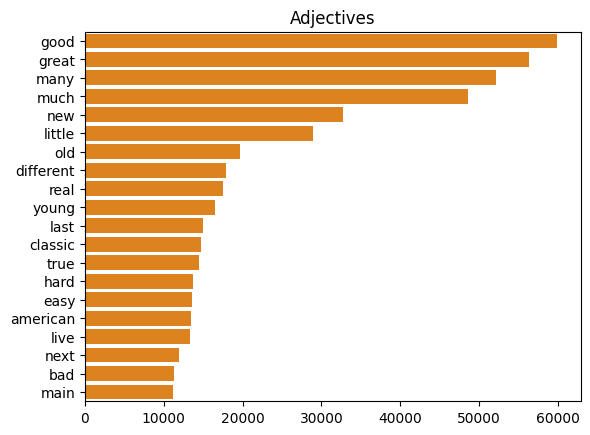

In [98]:
top20_adj = fd_adj.most_common(20)
top_sr = pd.Series(dict(top20_adj))
sns.barplot(y=top_sr.index, x=top_sr.values, color="#fb8500").set(title="Adjectives");

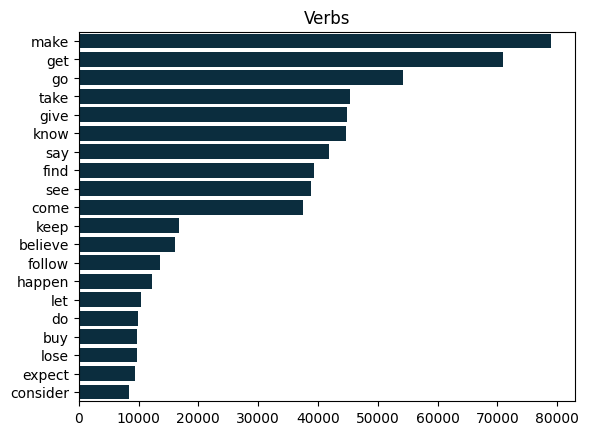

In [99]:
top20_vrb = fd_vrb.most_common(20)
top_sr = pd.Series(dict(top20_vrb))
sns.barplot(y=top_sr.index, x=top_sr.values, color="#023047").set(title="Verbs");

#### Models

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['sentiment'],
    test_size=0.2, random_state=42
)

# create pipelines for different classifiers
lr_pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
    LogisticRegression(max_iter=200, multi_class='multinomial')
)
rf_pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
    RandomForestClassifier()
)
svm_pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
    LinearSVC()
)

lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)

lr_pred = lr_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)
svm_pred = svm_pipeline.predict(X_test)

# predict on the testing data and evaluate accuracy
lr_accuracy = accuracy_score(y_test, lr_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.6f}")
print(f"Random Forest Accuracy:       {rf_accuracy:.6f}")
print(f"Linear SVM Accuracy:          {svm_accuracy:.6f}")

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression Accuracy: 0.880000
Random Forest Accuracy:       0.873375
Linear SVM Accuracy:          0.866775


In [101]:
from sklearn.metrics import classification_report

report = classification_report(y_test, lr_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.49      0.37      0.42      2544
     neutral       0.50      0.39      0.44      3238
    positive       0.93      0.96      0.95     34218

    accuracy                           0.88     40000
   macro avg       0.64      0.58      0.60     40000
weighted avg       0.87      0.88      0.87     40000



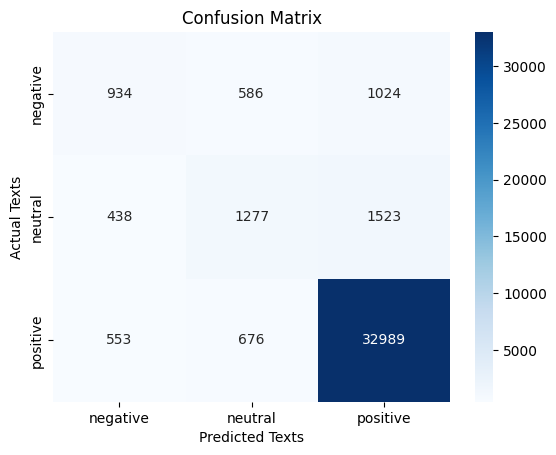

In [105]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred)
class_labels = ['negative', 'neutral', 'positive']
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Texts')
plt.ylabel('Actual Texts')
plt.title('Confusion Matrix')
plt.show()

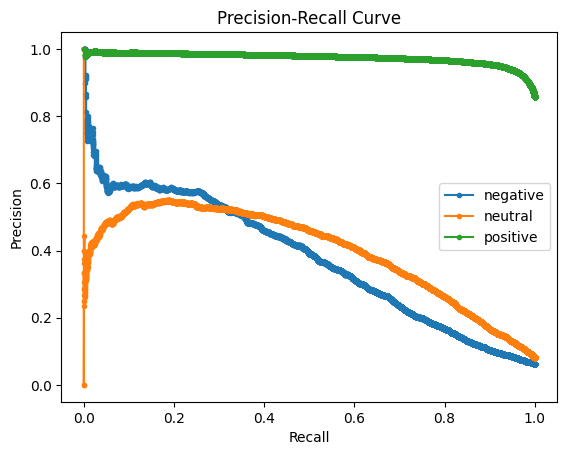

In [107]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

y_test_bin = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
lr_probabilities = lr_pipeline.predict_proba(X_test)

precision = dict()
recall = dict()
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], lr_probabilities[:, i])

plt.figure()
for i in range(len(class_labels)):
    plt.plot(recall[i], precision[i], marker='.', label=class_labels[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()